# Deep Learning and Inverse Problems - Summer 2024
## Problem Set 7

**Issued**: Tuesday, June 4, 2024, 1:00 pm

**Due**: Tuesday, June 11, 2024, 1:00 pm

# Denoising with a learned DNN prior

We consider the classical image or data denoising problem, where the goal is to remove zero-mean white Gaussian noise from a given image or data point. In more detail, our goal is to obtain an estimate of a vector $y_0 \in \mathbb R^n$ from the noisy observation
$$
y = y_0 + \eta, 
$$
where $\eta$ is zero-mean Gaussian noise with covariance matrix $\sigma^2/n I$, and $y_0$ lies in the range of the generator, i.e., $y_0=G(x_0)$.

We consider the following two-step denoising algorithm:
1. Obtaine an estimate $\hat x$ of the latent representation by minimizing the following empirical loss using gradient descent:
$$
f(x) = \|G(x) - y_0\|_2^2
$$

2. Obtain an estimate of the image as $\hat y = G(\hat x)$.

We learn G by training an encoder-decoder network (i.e., an autoencoder) and taking G as the decoder.

In [1]:
import torch
import torch.nn as nn
import torch.utils as utils
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F

import random
import numpy as np
import collections

## Get data

In [2]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test  = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

batch_size = 1
train_set = [ex for ex in torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True)]
test_set = [ex for ex in torch.utils.data.DataLoader(dataset=mnist_test,batch_size=batch_size,shuffle=True)]

# construct training and test set only consisting of twos
def extract_nu(set,nu):
    eset = []
    for image,label in set:
        if label.numpy() == nu:
            eset.append((image,label))
    return eset
train_twos = extract_nu(train_set,2)
test_twos = extract_nu(test_set,2)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:09<00:00, 1067898.60it/s]


Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 276528.26it/s]


Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 917528.15it/s] 


Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<?, ?it/s]


Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw



## Specification of the autoencoder

Below, specify the encoder and decoder parameterized by lengthbottleneck:
- Encoder: Two-layer linear neural network consisting of linear layer + relu + linear layer + relu. The first linear layer takes the 784 input neurons, maps it to 400 neurons, and the second layer maps the 400 neurons to lengthbottleneck neurons.
- Decoder: linear layer + relu + linear layer + relu; lengthbottleneck neurons -> 400 neurons -> 784 neurons

In [3]:
class Encoder(nn.Module):
    def __init__(self,lenbottleneck = 20):
        super(Encoder,self).__init__()
        self.fc1 = nn.Linear(28*28, 20*20)
        self.fc2 = nn.Linear(20*20,lenbottleneck)                
    def forward(self,x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self,lenbottleneck = 20):
        super(Decoder,self).__init__()
        self.fc1 = nn.Linear(lenbottleneck,20*20)
        self.fc2 = nn.Linear(20*20,28*28)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(28,28)
        return x

In [4]:
def train(encoder,decoder,trainset,learning_rate = 0.001,epoch = 10,device="cpu"):
    parameters = list(encoder.parameters()) + list(decoder.parameters())
    loss_func = nn.MSELoss() # mean square loss after the decoder 
    print("learning_rate: ",learning_rate)
    optimizer = torch.optim.SGD(parameters, lr=learning_rate)
    ctr = 0
    for i in range(epoch):
        print("at epoch ", i + 1 , "/", epoch)
        for (image,label) in trainset:
            ctr += 1
            image = Variable(image).to(device)
            optimizer.zero_grad()
            output = encoder(image)
            output = decoder(output)
            loss = loss_func(output.squeeze(), image.squeeze())
            loss.backward()
            optimizer.step()
    print("trained in ",ctr," iterations")
    return encoder, decoder

## Training autoencoders

In [5]:
# train autoencoder for all digits
K = 10
encoder10 = Encoder(K)
decoder10 = Decoder(K)
encoder,decoder = train(encoder10,decoder10,train_set[:10000],1.0)

learning_rate:  1.0
at epoch  1 / 10
at epoch  2 / 10
at epoch  3 / 10
at epoch  4 / 10
at epoch  5 / 10
at epoch  6 / 10
at epoch  7 / 10
at epoch  8 / 10
at epoch  9 / 10
at epoch  10 / 10
trained in  100000  iterations


In [6]:
# train autoencoder for all digits
K = 20
encoder20 = Encoder(K)
decoder20 = Decoder(K)
encoder20,decoder20 = train(encoder20,decoder20,train_set[:10000],1.0)

learning_rate:  1.0
at epoch  1 / 10
at epoch  2 / 10
at epoch  3 / 10
at epoch  4 / 10
at epoch  5 / 10
at epoch  6 / 10
at epoch  7 / 10
at epoch  8 / 10
at epoch  9 / 10
at epoch  10 / 10
trained in  100000  iterations


# Check output of autoencoder: print a few input/output pairs

In [7]:
# given two lists of images as np-arrays, plot them as a row
def plot_images(top,bottom):
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
    for images, row in zip([top, bottom], axes):
        for img, ax in zip(images, row):
            ax.imshow(img, cmap='Greys_r')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    fig.tight_layout(pad=0.1)
    return fig

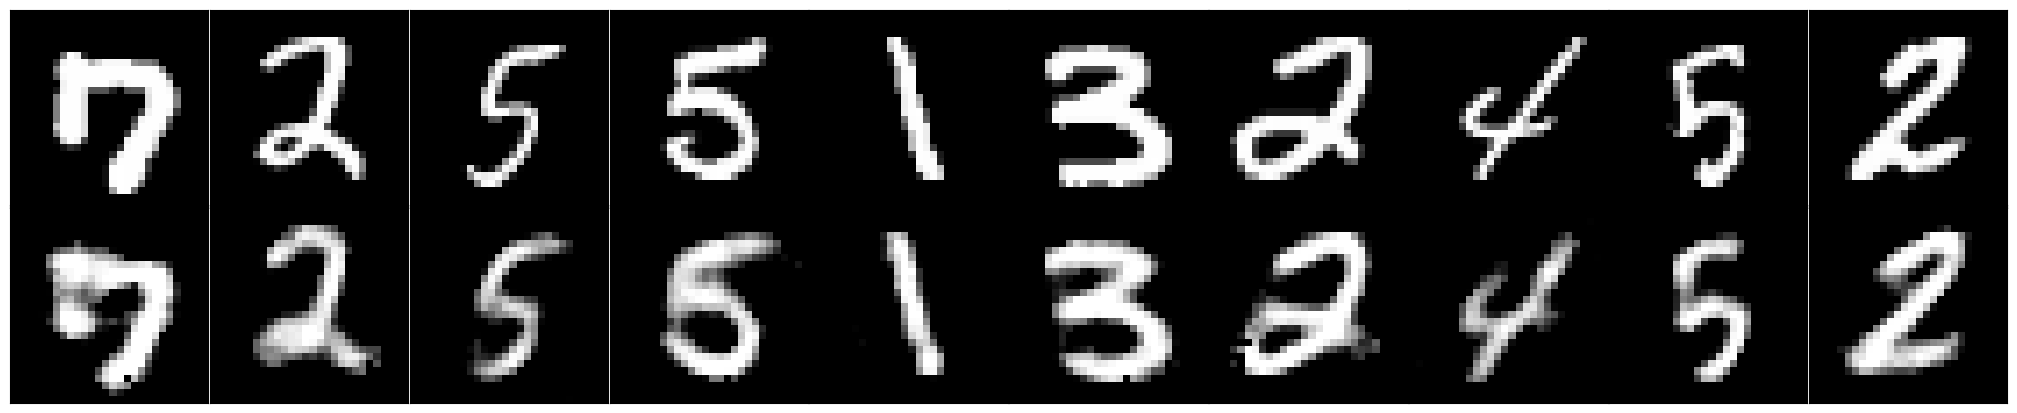

In [8]:
in_imgs = []
out_imgs = []
numprint = 10
for i,(img,label) in enumerate(test_set):
    if i >= numprint:
        break
    out_img = decoder20(encoder20(Variable(img)))
    in_imgs += [img[0][0].numpy()] # img is 1x1x28x28 tensor
    out_img.data.clamp_(0, 1)
    out_imgs += [out_img.data.numpy()]

fig = plot_images(in_imgs,out_imgs)

# Task 1

### Denoising with a trained decoder

Write the function for denoising below that denoises a noisy image given a generator learned earlier that maps a K-dimensional input space to an image. 

In [46]:
# denoise by recovering estimating a latent representation and passing that through the decoder
def denoise(net,noisy_image,K):

    ## your code here
    x= torch.randn(1, K, requires_grad=True)
    lcost = nn.MSELoss()
    loc_optim = torch.optim.SGD([x], lr=0.001, momentum=0.9)
    # import pdb; pdb.set_trace()
    for _ in range(10):
        loc_optim.zero_grad()
        ## forward pass
        Gx = net(x)
        ## backward pass
        cost = lcost(Gx, noisy_image)
        cost.backward()
        loc_optim.step()
        
    # pdb.set_trace()
    recovered_img = net(x)
    
    return recovered_img


## Visualize denoising performance

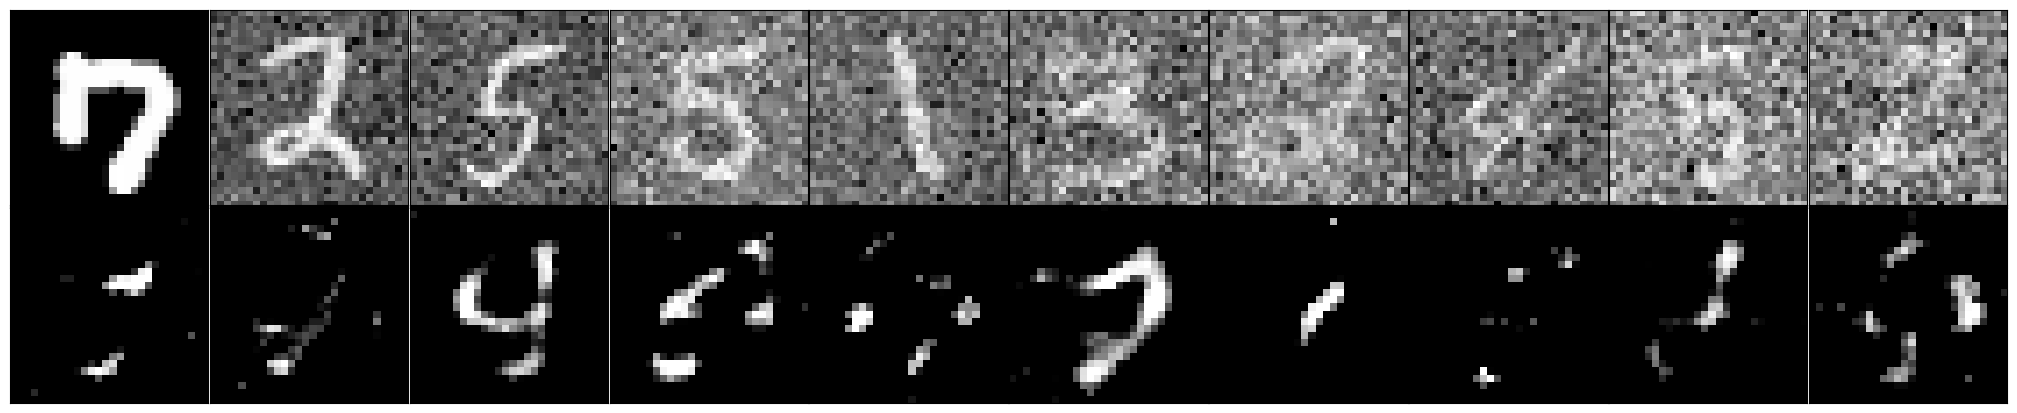

In [44]:
K = 20
Sigmas = [0.3*i for i in range(10)] # noise variances
noisy_imgs = []
rec_imgs = []
for (img,label),sigma in zip(test_set[:len(Sigmas)],Sigmas):
    img = img[0][0]
    noise = np.sqrt(sigma)*torch.norm(img)/np.sqrt(28*28)*torch.randn(28, 28)
    noisy_img = img + noise
    rec_img = denoise(decoder20,Variable(noisy_img),K)
    rec_img.data.clamp_(0, 1)
    noisy_imgs += [noisy_img.numpy()]
    rec_imgs += [rec_img.data.numpy()]

# plot and save to file
fig = plot_images(noisy_imgs,rec_imgs)
fig.savefig("denoising_ex_0.1.png")

# Task 2

Compare empirically which network performs better (the one with K=10, or the one with K=20). Your choice how to do this comparison.

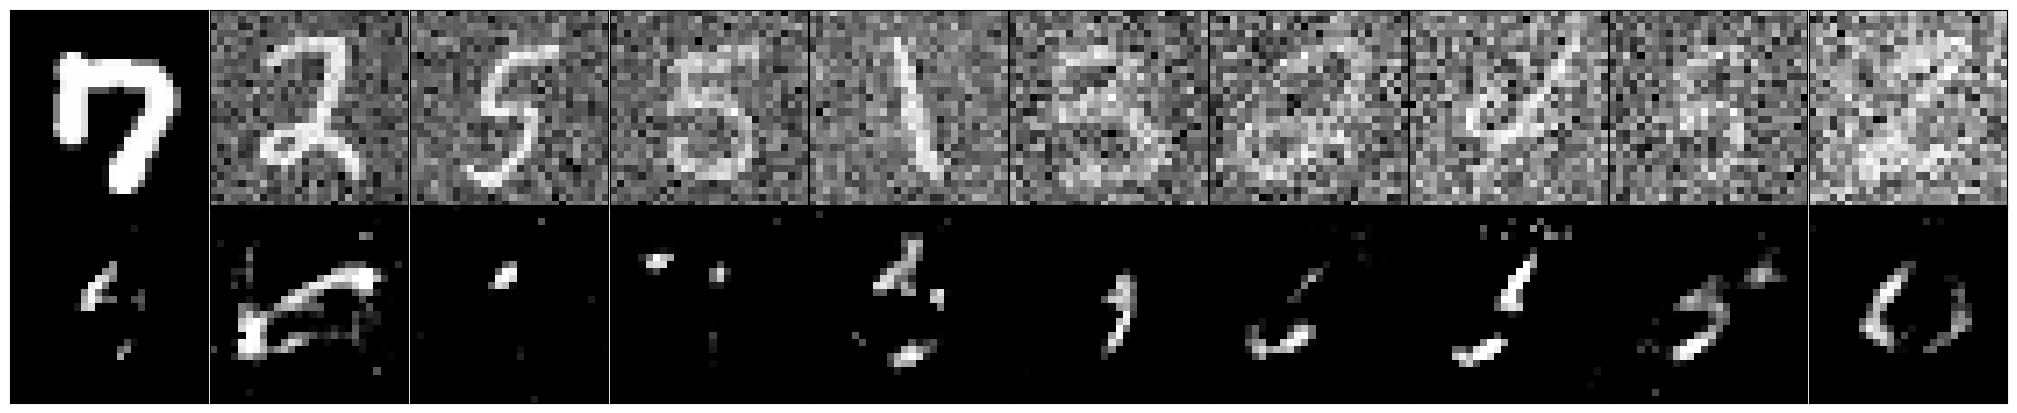

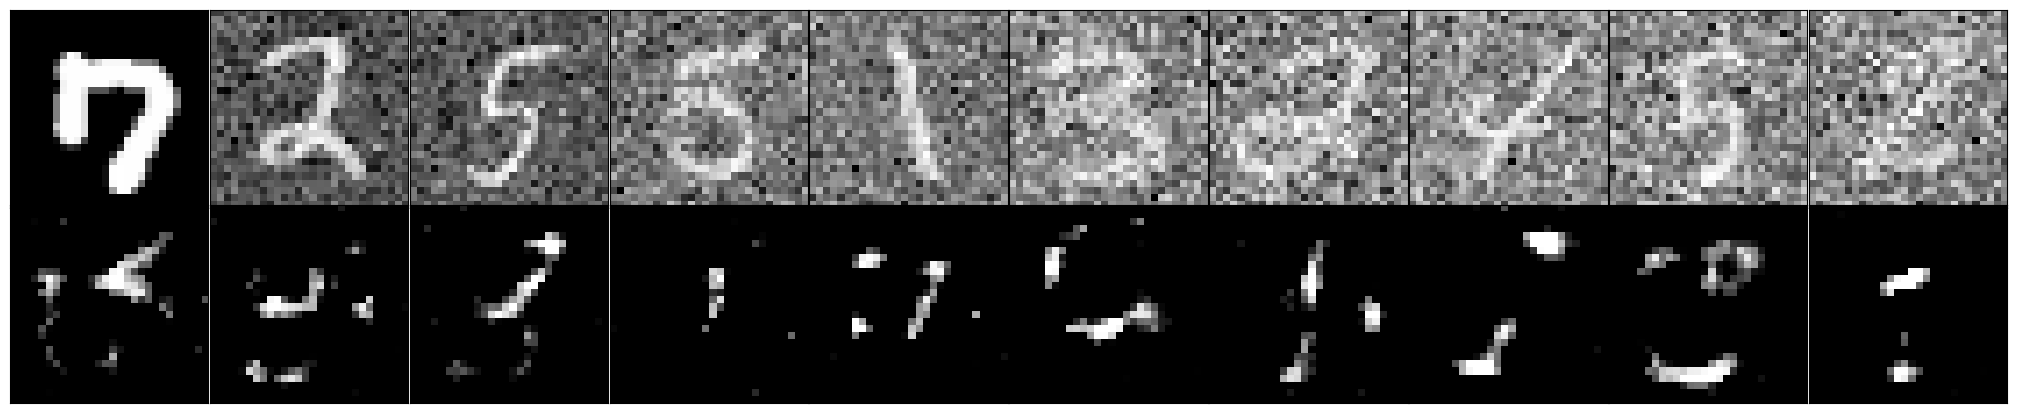

In [47]:
for K in [10,20]:
    Sigmas = [0.3*i for i in range(10)] # noise variances
    noisy_imgs = []
    rec_imgs = []
    for (img,label),sigma in zip(test_set[:len(Sigmas)],Sigmas):
        img = img[0][0]
        noise = np.sqrt(sigma)*torch.norm(img)/np.sqrt(28*28)*torch.randn(28, 28)
        noisy_img = img + noise
        if K == 10:
            rec_img = denoise(decoder10,Variable(noisy_img),K)
        elif K == 20:
            rec_img = denoise(decoder20,Variable(noisy_img),K)
        rec_img.data.clamp_(0, 1)
        noisy_imgs += [noisy_img.numpy()]
        rec_imgs += [rec_img.data.numpy()]

    # plot and save to file
    fig = plot_images(noisy_imgs,rec_imgs)
    fig.savefig("denoising_ex_0.1.png")